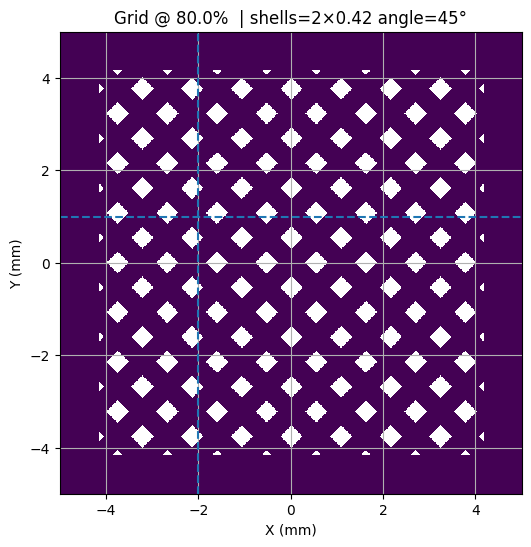

==== Grid Infill 80.0% ====
XY Total Area         = 87.0324 mm²
  Shell Area          = 31.1879 mm²
  Infill Area         = 55.8445 mm²
I_x                   = 764.6175
I_y                   = 764.6175
I_xy                  = 0.0000
Polar moment, J       = 1529.2350
-- Cross-sections through Z (pattern constant over Z) --
Length along X @ y=1.000 mm: 7.4593 mm
Length along Y @ x=-2.000 mm: 8.6108 mm
Area of XZ plane @ y=1.000: 149.1865 mm²  (Z=20.000 mm)
Area of YZ plane @ x=-2.000: 172.2153 mm²  (Z=20.000 mm)

A_xz(y=1mm) = 149.18648310388022 mm^2
A_yz(x=-2mm) = 172.21526908635838 mm^2


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Geometry utilities
# ------------------------------

def _dist_mod(u, spacing):
    """Distance to nearest line center in a periodic family with pitch=spacing."""
    r = np.mod(u, spacing)
    return np.minimum(r, spacing - r)

def _rectilinear_mask(XX, YY, spacing, line_width, angle_deg=0.0, phase=0.0):
    """
    Rectilinear (parallel lines) mask at angle_deg, with true line width.
    Lines are centered where (x cos + y sin + phase) is a multiple of spacing.
    """
    th = np.deg2rad(angle_deg)
    # Coordinate along the line-normal direction (u-axis)
    u =  XX * np.cos(th) + YY * np.sin(th)
    dist = _dist_mod(u + phase, spacing)
    # Render a line of width 'line_width' around the center => half width threshold
    return dist <= (line_width / 2.0)

def _spacing_for_grid_density(line_width, f):
    """
    For a two-axis grid (two orthogonal families of rectilinear lines with true width 'w'),
    the area fraction is f = 2r - r^2 where r = w/s.
    Solve for s: r = 1 - sqrt(1 - f)  =>  s = w / r.
    """
    f = float(np.clip(f, 0.0, 1.0))
    if f <= 0.0:
        return np.inf
    if f >= 1.0:
        return line_width  # centers are one line_width apart for a "solid" raster
    r = 1.0 - np.sqrt(1.0 - f)
    return line_width / r

# ------------------------------
# Area & inertia on a raster mask
# ------------------------------

def compute_area_moments(XX, YY, mask):
    x_vals = XX[mask]
    y_vals = YY[mask]

    if x_vals.size == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A   = x_vals.size * dA
    x_c = float(np.mean(x_vals))
    y_c = float(np.mean(y_vals))

    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = float(np.sum(y_shift**2) * dA)
    I_y = float(np.sum(x_shift**2) * dA)
    I_xy = float(np.sum(x_shift * y_shift) * dA)
    J   = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

# ------------------------------
# Main: Prusa-style rectilinear/grid with shells
# ------------------------------

def prusa_style_grid_or_rectilinear(
    width, height,
    infill_fraction,
    line_width=0.42,
    shell_layers=2,
    base_infill_angle_deg=45.0,
    grid=True,
    z_height=0.0,              # keep for optional phase control
    phase_per_mm=0.0,
    # --- NEW: cross-sections extruded through Z ---
    z_object_height=None,      # mm (required to report XZ / YZ areas)
    y_plane=0.0,               # mm, plane parallel to XZ at y = y_plane
    x_plane=0.0,               # mm, plane parallel to YZ at x = x_plane
    N=800,
    plot=True,
    verbose=True
):
    # ----- Raster grid
    xs = np.linspace(-width/2,  width/2,  N)
    ys = np.linspace(-height/2, height/2, N)
    XX, YY = np.meshgrid(xs, ys)

    # ----- Shells (perimeters)
    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(shell_layers):
        off = (i + 0.5) * line_width
        shell_mask |= np.abs(XX - (-width/2  + off)) <= (line_width / 2)
        shell_mask |= np.abs(XX - ( +width/2  - off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - (-height/2 + off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - ( +height/2 - off)) <= (line_width / 2)

    # ----- Infill region (inside shells)
    inner_offset = shell_layers * line_width
    inner_rect = (
        (np.abs(XX) <= (width/2  - inner_offset)) &
        (np.abs(YY) <= (height/2 - inner_offset))
    )

    if infill_fraction <= 0.0:
        infill_mask = np.zeros_like(XX, dtype=bool)
    elif infill_fraction >= 1.0:
        spacing = line_width
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect
    else:
        spacing = _spacing_for_grid_density(line_width, infill_fraction) if grid \
                  else line_width / infill_fraction
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect

    # ----- Final mask (material present)
    final_mask = shell_mask | infill_mask

    # ----- Plot
    if plot:
        plt.figure(figsize=(6, 6))
        img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(img, origin='lower',
                   extent=[-width/2, width/2, -height/2, height/2],
                   interpolation='nearest')
        title = "Grid" if grid else "Rectilinear"
        plt.title(f"{title} @ {infill_fraction*100:.1f}%  | shells={shell_layers}×{line_width:.2f} angle={base_infill_angle_deg:.0f}°")
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)

        # guide lines
        plt.hlines(y_plane, -width/2, width/2, linestyles='--')
        plt.vlines(x_plane, -height/2, height/2, linestyles='--')

        plt.show()

    # ----- XY numbers
    total = compute_area_moments(XX, YY, final_mask)
    shells = compute_area_moments(XX, YY, shell_mask)
    A_infill = total["A"] - shells["A"]

    # ----- NEW: cross-sections parallel to XZ and YZ
    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]

    ys = YY[:, 0]
    xs = XX[0, :]
    row = int(np.argmin(np.abs(ys - y_plane)))
    col = int(np.argmin(np.abs(xs - x_plane)))

    length_x_at_y = float(np.count_nonzero(final_mask[row, :]) * dx)
    length_y_at_x = float(np.count_nonzero(final_mask[:, col]) * dy)

    area_xz_at_y = None
    area_yz_at_x = None
    if z_object_height is not None and z_object_height > 0:
        area_xz_at_y = length_x_at_y * z_object_height
        area_yz_at_x = length_y_at_x * z_object_height

    if verbose:
        print(f"==== {('Grid' if grid else 'Rectilinear')} Infill {infill_fraction*100:.1f}% ====")
        print(f"XY Total Area         = {total['A']:.4f} mm²")
        print(f"  Shell Area          = {shells['A']:.4f} mm²")
        print(f"  Infill Area         = {A_infill:.4f} mm²")
        print(f"I_x                   = {total['I_x']:.4f}")
        print(f"I_y                   = {total['I_y']:.4f}")
        print(f"I_xy                  = {total['I_xy']:.4f}")
        print(f"Polar moment, J       = {total['J']:.4f}")
        print(f"-- Cross-sections through Z (pattern constant over Z) --")
        print(f"Length along X @ y={y_plane:.3f} mm: {length_x_at_y:.4f} mm")
        print(f"Length along Y @ x={x_plane:.3f} mm: {length_y_at_x:.4f} mm")
        if area_xz_at_y is not None:
            print(f"Area of XZ plane @ y={y_plane:.3f}: {area_xz_at_y:.4f} mm²  (Z={z_object_height:.3f} mm)")
        if area_yz_at_x is not None:
            print(f"Area of YZ plane @ x={x_plane:.3f}: {area_yz_at_x:.4f} mm²  (Z={z_object_height:.3f} mm)")
        print()

    return {
        "mask": final_mask,
        "XX": XX, "YY": YY,
        "dx": dx, "dy": dy,
        "area_total_xy": total["A"],
        "area_shells_xy": shells["A"],
        "area_infill_xy": A_infill,
        "moments_xy": total,
        "length_x_at_y": length_x_at_y,
        "length_y_at_x": length_y_at_x,
        "area_xz_at_y": area_xz_at_y,
        "area_yz_at_x": area_yz_at_x,
    }

# ------------------------------
# Demo
# ------------------------------
if __name__ == "__main__":
    W, H = 10.0, 10.0
    Z = 20.0  # object height in Z
    res = prusa_style_grid_or_rectilinear(
        width=W, height=H,
        infill_fraction=0.8,
        line_width=0.42,
        shell_layers=2,
        base_infill_angle_deg=45.0,
        grid=True,
        z_object_height=Z,  # << set Z height
        y_plane=+1.0,       # XZ cross-section at y = +1 mm
        x_plane=-2.0,       # YZ cross-section at x = -2 mm
        plot=True, verbose=True
    )

    print("A_xz(y=1mm) =", res["area_xz_at_y"], "mm^2")
    print("A_yz(x=-2mm) =", res["area_yz_at_x"], "mm^2")



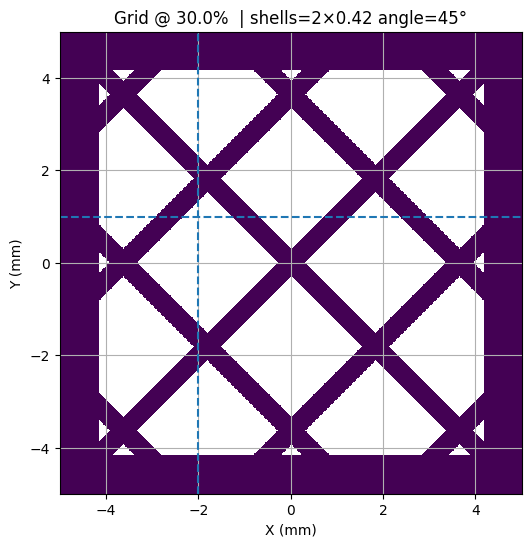

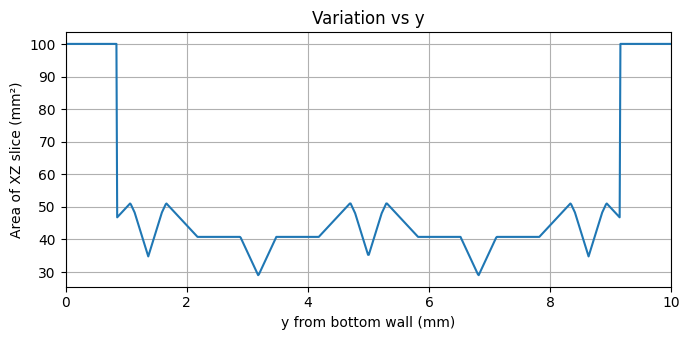

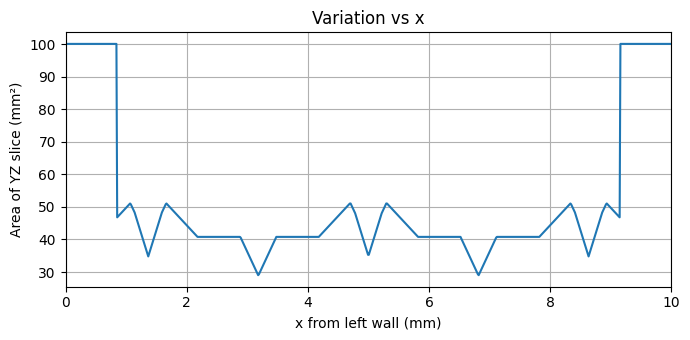

==== Grid Infill 30.0% ====
XY Total Area         = 52.1754 mm²
  Shell Area          = 31.1879 mm²
  Infill Area         = 20.9874 mm²
I_x                   = 567.1050
I_y                   = 567.1050
I_xy                  = 0.0000
Polar moment, J       = 1134.2101
-- Cross-sections through Z (pattern constant over Z) --
Length along X @ y=1.000 mm: 4.0801 mm
Length along Y @ x=-2.000 mm: 3.6045 mm
Area of XZ plane @ y=1.000: 40.8010 mm²  (Z=10.000 mm)
Area of YZ plane @ x=-2.000: 36.0451 mm²  (Z=10.000 mm)

A_xz(y=1mm) = 40.80100125156456 mm^2
A_yz(x=-2mm) = 36.04505632040059 mm^2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Geometry utilities
# ------------------------------

def _dist_mod(u, spacing):
    r = np.mod(u, spacing)
    return np.minimum(r, spacing - r)

def _rectilinear_mask(XX, YY, spacing, line_width, angle_deg=0.0, phase=0.0):
    th = np.deg2rad(angle_deg)
    u =  XX * np.cos(th) + YY * np.sin(th)
    dist = _dist_mod(u + phase, spacing)
    return dist <= (line_width / 2.0)

def _spacing_for_grid_density(line_width, f):
    f = float(np.clip(f, 0.0, 1.0))
    if f <= 0.0:
        return np.inf
    if f >= 1.0:
        return line_width
    r = 1.0 - np.sqrt(1.0 - f)
    return line_width / r

# ------------------------------
# Area & inertia on a raster mask
# ------------------------------

def compute_area_moments(XX, YY, mask):
    x_vals = XX[mask]
    y_vals = YY[mask]

    if x_vals.size == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A   = x_vals.size * dA
    x_c = float(np.mean(x_vals))
    y_c = float(np.mean(y_vals))

    x_shift = x_vals - x_c
    y_shift = y_vals - y_c

    I_x = float(np.sum(y_shift**2) * dA)
    I_y = float(np.sum(x_shift**2) * dA)
    I_xy = float(np.sum(x_shift * y_shift) * dA)
    J   = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

# ------------------------------
# Main: Prusa-style rectilinear/grid with shells
# ------------------------------

def prusa_style_grid_or_rectilinear(
    width, height,
    infill_fraction,
    line_width=0.42,
    shell_layers=2,
    base_infill_angle_deg=45.0,
    grid=True,
    z_height=0.0,              # optional phase control
    phase_per_mm=0.0,
    # Cross-sections extruded through Z
    z_object_height=None,      # mm (if set => areas in mm²; else lengths in mm)
    y_plane=0.0,               # mm, plane parallel to XZ at y = y_plane
    x_plane=0.0,               # mm, plane parallel to YZ at x = x_plane
    N=800,
    plot=True,
    verbose=True
):
    # ----- Raster grid (centered at origin)
    xs = np.linspace(-width/2,  width/2,  N)
    ys = np.linspace(-height/2, height/2, N)
    XX, YY = np.meshgrid(xs, ys)

    # ----- Shells (perimeters)
    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(shell_layers):
        off = (i + 0.5) * line_width
        shell_mask |= np.abs(XX - (-width/2  + off)) <= (line_width / 2)
        shell_mask |= np.abs(XX - ( +width/2  - off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - (-height/2 + off)) <= (line_width / 2)
        shell_mask |= np.abs(YY - ( +height/2 - off)) <= (line_width / 2)

    # ----- Infill region (inside shells)
    inner_offset = shell_layers * line_width
    inner_rect = (
        (np.abs(XX) <= (width/2  - inner_offset)) &
        (np.abs(YY) <= (height/2 - inner_offset))
    )

    if infill_fraction <= 0.0:
        infill_mask = np.zeros_like(XX, dtype=bool)
    elif infill_fraction >= 1.0:
        spacing = line_width
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect
    else:
        spacing = _spacing_for_grid_density(line_width, infill_fraction) if grid \
                  else line_width / infill_fraction
        masks = []
        angles = [base_infill_angle_deg] + ([base_infill_angle_deg + 90] if grid else [])
        phase = phase_per_mm * z_height
        for a in angles:
            masks.append(_rectilinear_mask(XX, YY, spacing, line_width, angle_deg=a, phase=phase))
        infill_mask = np.logical_or.reduce(masks) & inner_rect

    # ----- Final mask (material present)
    final_mask = shell_mask | infill_mask

    # ----- Plot: XY bitmap preview
    if plot:
        plt.figure(figsize=(6, 6))
        img = np.where(final_mask, 1.0, np.nan)
        plt.imshow(img, origin='lower',
                   extent=[-width/2, width/2, -height/2, height/2],
                   interpolation='nearest')
        title = "Grid" if grid else "Rectilinear"
        plt.title(f"{title} @ {infill_fraction*100:.1f}%  | shells={shell_layers}×{line_width:.2f} angle={base_infill_angle_deg:.0f}°")
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)

        # guide lines
        plt.hlines(y_plane, -width/2, width/2, linestyles='--')
        plt.vlines(x_plane, -height/2, height/2, linestyles='--')

        plt.show()

    # ----- XY numbers
    total = compute_area_moments(XX, YY, final_mask)
    shells = compute_area_moments(XX, YY, shell_mask)
    A_infill = total["A"] - shells["A"]

    # ----- Cross-sections parallel to XZ and YZ at specific planes
    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    ys_centered = YY[:, 0]
    xs_centered = XX[0, :]
    row = int(np.argmin(np.abs(ys_centered - y_plane)))
    col = int(np.argmin(np.abs(xs_centered - x_plane)))

    length_x_at_y = float(np.count_nonzero(final_mask[row, :]) * dx)
    length_y_at_x = float(np.count_nonzero(final_mask[:, col]) * dy)

    area_xz_at_y = None
    area_yz_at_x = None
    if z_object_height is not None and z_object_height > 0:
        area_xz_at_y = length_x_at_y * z_object_height
        area_yz_at_x = length_y_at_x * z_object_height

    # ----- NEW: Variation curves over full width/height
    # lengths per row/column
    length_x_vs_y = np.count_nonzero(final_mask, axis=1) * dx   # for each y-row, length along X
    length_y_vs_x = np.count_nonzero(final_mask, axis=0) * dy   # for each x-col, length along Y

    if z_object_height is not None and z_object_height > 0:
        area_xz_vs_y = length_x_vs_y * z_object_height
        area_yz_vs_x = length_y_vs_x * z_object_height
        y_label_curves = "Area of XZ slice (mm²)"
        x_label_curves = "Area of YZ slice (mm²)"
    else:
        area_xz_vs_y = length_x_vs_y
        area_yz_vs_x = length_y_vs_x
        y_label_curves = "Length along X (mm)  [set z_object_height for area]"
        x_label_curves = "Length along Y (mm)  [set z_object_height for area]"

    # axes remapped to start at 0 (wall) → up to width/height
    y_axis_0_to_H = ys_centered + height/2.0
    x_axis_0_to_W = xs_centered + width/2.0

    if plot:
        # --- Area vs y (XZ plane area as y varies)
        plt.figure(figsize=(7, 3.5))
        plt.plot(y_axis_0_to_H, area_xz_vs_y)
        plt.xlabel("y from bottom wall (mm)")
        plt.ylabel(y_label_curves)
        plt.title("Variation vs y")
        plt.grid(True)
        plt.xlim(0, height)
        plt.tight_layout()
        plt.show()

        # --- Area vs x (YZ plane area as x varies)
        plt.figure(figsize=(7, 3.5))
        plt.plot(x_axis_0_to_W, area_yz_vs_x)
        plt.xlabel("x from left wall (mm)")
        plt.ylabel(x_label_curves)
        plt.title("Variation vs x")
        plt.grid(True)
        plt.xlim(0, width)
        plt.tight_layout()
        plt.show()

    if verbose:
        print(f"==== {('Grid' if grid else 'Rectilinear')} Infill {infill_fraction*100:.1f}% ====")
        print(f"XY Total Area         = {total['A']:.4f} mm²")
        print(f"  Shell Area          = {shells['A']:.4f} mm²")
        print(f"  Infill Area         = {A_infill:.4f} mm²")
        print(f"I_x                   = {total['I_x']:.4f}")
        print(f"I_y                   = {total['I_y']:.4f}")
        print(f"I_xy                  = {total['I_xy']:.4f}")
        print(f"Polar moment, J       = {total['J']:.4f}")
        print(f"-- Cross-sections through Z (pattern constant over Z) --")
        print(f"Length along X @ y={y_plane:.3f} mm: {length_x_at_y:.4f} mm")
        print(f"Length along Y @ x={x_plane:.3f} mm: {length_y_at_x:.4f} mm")
        if area_xz_at_y is not None:
            print(f"Area of XZ plane @ y={y_plane:.3f}: {area_xz_at_y:.4f} mm²  (Z={z_object_height:.3f} mm)")
        if area_yz_at_x is not None:
            print(f"Area of YZ plane @ x={x_plane:.3f}: {area_yz_at_x:.4f} mm²  (Z={z_object_height:.3f} mm)")
        print()

    return {
        "mask": final_mask,
        "XX": XX, "YY": YY,
        "dx": dx, "dy": dy,
        "area_total_xy": total["A"],
        "area_shells_xy": shells["A"],
        "area_infill_xy": A_infill,
        "moments_xy": total,
        "length_x_at_y": length_x_at_y,
        "length_y_at_x": length_y_at_x,
        "area_xz_at_y": area_xz_at_y,
        "area_yz_at_x": area_yz_at_x,
        # NEW: full variation arrays and their axes (0→W/H)
        "y_axis_mm": y_axis_0_to_H,
        "x_axis_mm": x_axis_0_to_W,
        "area_xz_vs_y": area_xz_vs_y,
        "area_yz_vs_x": area_yz_vs_x,
    }

# ------------------------------
# Demo
# ------------------------------
if __name__ == "__main__":
    W, H = 10.0, 10.0
    Z = 10.0  # object height in Z
    res = prusa_style_grid_or_rectilinear(
        width=W, height=H,
        infill_fraction=0.3,
        line_width=0.42,
        shell_layers=2,
        base_infill_angle_deg=45.0,
        grid=True,
        z_object_height=Z,  # set Z height for true areas
        y_plane=+1.0,       # XZ cross-section at y = +1 mm
        x_plane=-2.0,       # YZ cross-section at x = -2 mm (centered coords)
        N=800,
        plot=True, verbose=True
    )

    print("A_xz(y=1mm) =", res["area_xz_at_y"], "mm^2")
    print("A_yz(x=-2mm) =", res["area_yz_at_x"], "mm^2")


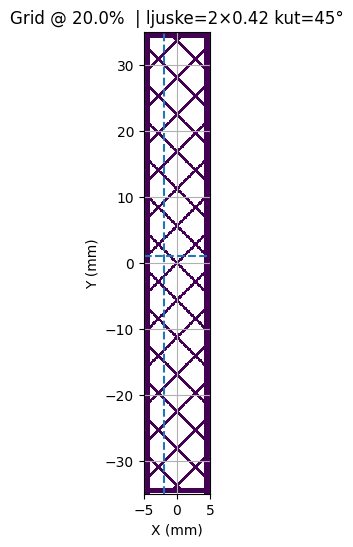

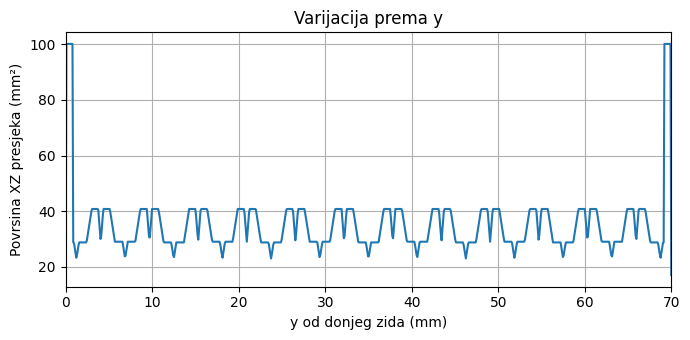

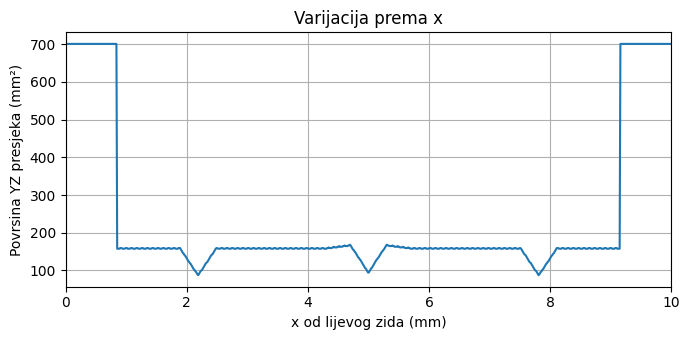

==== Grid ispuna 20.0% ====
XY ukupna povrsina     = 245.4207 mm²
  Povrsina ljuski      = 132.4033 mm²
  Povrsina ispune      = 113.0174 mm²
-- Presjeci kroz Z (uzorak konstantan po Z) --
Duzina po X @ y=1.000 mm: 2.8786 mm
Duzina po Y @ x=-2.000 mm: 15.9449 mm
Povrsina XZ @ y=1.000: 28.7860 mm²  (Z=10.000 mm)
Povrsina YZ @ x=-2.000: 159.4493 mm²  (Z=10.000 mm)

A_xz(y=1mm) = 28.785982478097694 mm^2
A_yz(x=-2mm) = 159.44931163954337 mm^2


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Geometrijske pomocne funkcije
# ------------------------------

def _udaljenost_mod(u, razmak):
    """Najmanja udaljenost do najblize paralelne linije s periodom 'razmak'."""
    r = np.mod(u, razmak)
    return np.minimum(r, razmak - r)

def _pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=0.0, faza=0.0):
    """
    Generira pravocrtni uzorak (paralelne linije) kao booleovu masku.
    XX, YY: mreza koordinata; razmak: period linija; sirina_linije: debljina trake.
    kut_stupnjevi: orijentacija linija; faza: pomak uzorka.
    """
    th = np.deg2rad(kut_stupnjevi)
    u =  XX * np.cos(th) + YY * np.sin(th)
    dist = _udaljenost_mod(u + faza, razmak)
    return dist <= (sirina_linije / 2.0)

def _razmak_za_gustocu_mreze(sirina_linije, f):
    """
    Za zadani udio ispune f (0..1) vrati razmak linija koji daje istu gustocu
    kod 'grid' (dvije orijentacije pod 90°). Za cistu pravocrtnu (jedna orijentacija)
    koristi se sirina_linije / f (vidi dolje).
    """
    f = float(np.clip(f, 0.0, 1.0))
    if f <= 0.0:
        return np.inf
    if f >= 1.0:
        return sirina_linije
    r = 1.0 - np.sqrt(1.0 - f)
    return sirina_linije / r

# ------------------------------
# Povrsina i momenti na raster maski
# ------------------------------

def izracun_povrsine_i_momenata(XX, YY, maska):
    """
    Racuna povrsinu A, te geometrijske momente inercije oko tezista (I_x, I_y, I_xy)
    na raster reprezentaciji (True piksli su 'materijal').
    """
    x_vals = XX[maska]
    y_vals = YY[maska]

    if x_vals.size == 0:
        return {"A": 0.0, "x_c": 0.0, "y_c": 0.0, "I_x": 0.0, "I_y": 0.0, "I_xy": 0.0, "J": 0.0}

    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    dA = dx * dy

    A   = x_vals.size * dA
    x_c = float(np.mean(x_vals))
    y_c = float(np.mean(y_vals))

    x_p = x_vals - x_c
    y_p = y_vals - y_c

    I_x = float(np.sum(y_p**2) * dA)
    I_y = float(np.sum(x_p**2) * dA)
    I_xy = float(np.sum(x_p * y_p) * dA)
    J   = I_x + I_y

    return {"A": A, "x_c": x_c, "y_c": y_c, "I_x": I_x, "I_y": I_y, "I_xy": I_xy, "J": J}

# ------------------------------
# Glavno: Prusa-stil pravocrtni/grid s ljuskama (perimetrima)
# ------------------------------

def prusa_mreza_ili_pravocrtna(
    sirina, visina,
    udio_ispune,
    sirina_linije=0.42,
    slojevi_ljuske=2,
    osnovni_kut_ispune_stupnjevi=45.0,
    mreza=True,
    z_visina=0.0,         # opcionalna faza po Z
    faza_po_mm=0.0,
    # Poprecni presjeci kroz Z
    z_visina_objekta=None,  # mm (ako je postavljeno -> povrsine u mm²; inace duzine u mm)
    y_ravnina=0.0,          # mm, ravnina paralelna s XZ na y = y_ravnina
    x_ravnina=0.0,          # mm, ravnina paralelna s YZ na x = x_ravnina
    N=800,
    graficki_prikaz=True,
    detaljno=True
):
    # ----- Raster mreza (centar u ishodištu)
    xs = np.linspace(-sirina/2,  sirina/2,  N)
    ys = np.linspace(-visina/2, visina/2, N)
    XX, YY = np.meshgrid(xs, ys)

    # ----- Ljuske (perimetri)
    shell_mask = np.zeros_like(XX, dtype=bool)
    for i in range(slojevi_ljuske):
        off = (i + 0.5) * sirina_linije
        shell_mask |= np.abs(XX - (-sirina/2  + off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(XX - ( +sirina/2  - off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(YY - (-visina/2 + off)) <= (sirina_linije / 2)
        shell_mask |= np.abs(YY - ( +visina/2 - off)) <= (sirina_linije / 2)

    # ----- Unutarnji pravokutnik (podrucje ispune)
    unutarnji_pomak = slojevi_ljuske * sirina_linije
    unutarnji_pravokutnik = (
        (np.abs(XX) <= (sirina/2  - unutarnji_pomak)) &
        (np.abs(YY) <= (visina/2 - unutarnji_pomak))
    )

    # ----- Ispuna
    if udio_ispune <= 0.0:
        infill_mask = np.zeros_like(XX, dtype=bool)
    elif udio_ispune >= 1.0:
        razmak = sirina_linije
        maske = []
        kutevi = [osnovni_kut_ispune_stupnjevi] + ([osnovni_kut_ispune_stupnjevi + 90] if mreza else [])
        faza = faza_po_mm * z_visina
        for a in kutevi:
            maske.append(_pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=a, faza=faza))
        infill_mask = np.logical_or.reduce(maske) & unutarnji_pravokutnik
    else:
        razmak = _razmak_za_gustocu_mreze(sirina_linije, udio_ispune) if mreza \
                 else sirina_linije / udio_ispune
        maske = []
        kutevi = [osnovni_kut_ispune_stupnjevi] + ([osnovni_kut_ispune_stupnjevi + 90] if mreza else [])
        faza = faza_po_mm * z_visina
        for a in kutevi:
            maske.append(_pravocrtna_maska(XX, YY, razmak, sirina_linije, kut_stupnjevi=a, faza=faza))
        infill_mask = np.logical_or.reduce(maske) & unutarnji_pravokutnik

    # ----- Konacna maska (materijal prisutan)
    konacna_maska = shell_mask | infill_mask

    # ----- Graficki pregled XY
    if graficki_prikaz:
        plt.figure(figsize=(6, 6))
        img = np.where(konacna_maska, 1.0, np.nan)
        plt.imshow(img, origin='lower',
                   extent=[-sirina/2, sirina/2, -visina/2, visina/2],
                   interpolation='nearest')
        naslov = "Grid" if mreza else "Pravocrtna"
        plt.title(f"{naslov} @ {udio_ispune*100:.1f}%  | ljuske={slojevi_ljuske}×{sirina_linije:.2f} kut={osnovni_kut_ispune_stupnjevi:.0f}°")
        plt.xlabel("X (mm)")
        plt.ylabel("Y (mm)")
        plt.gca().set_aspect('equal', 'box')
        plt.grid(True)
        # vodilice
        plt.hlines(y_ravnina, -sirina/2, sirina/2, linestyles='--')
        plt.vlines(x_ravnina, -visina/2, visina/2, linestyles='--')
        plt.show()

    # ----- XY brojke
    total = izracun_povrsine_i_momenata(XX, YY, konacna_maska)
    ljuske = izracun_povrsine_i_momenata(XX, YY, shell_mask)
    A_ispuna = total["A"] - ljuske["A"]

    # ----- Presjeci paralelni s XZ i YZ kroz zadane ravnine
    dx = XX[0, 1] - XX[0, 0]
    dy = YY[1, 0] - YY[0, 0]
    ys_centered = YY[:, 0]
    xs_centered = XX[0, :]
    row = int(np.argmin(np.abs(ys_centered - y_ravnina)))
    col = int(np.argmin(np.abs(xs_centered - x_ravnina)))

    duzina_x_na_y = float(np.count_nonzero(konacna_maska[row, :]) * dx)
    duzina_y_na_x = float(np.count_nonzero(konacna_maska[:, col]) * dy)

    povrsina_xz_na_y = None
    povrsina_yz_na_x = None
    if z_visina_objekta is not None and z_visina_objekta > 0:
        povrsina_xz_na_y = duzina_x_na_y * z_visina_objekta
        povrsina_yz_na_x = duzina_y_na_x * z_visina_objekta

    # ----- Krivulje varijacije preko cijele visine/sirine
    duzina_x_vs_y = np.count_nonzero(konacna_maska, axis=1) * dx
    duzina_y_vs_x = np.count_nonzero(konacna_maska, axis=0) * dy

    if z_visina_objekta is not None and z_visina_objekta > 0:
        povrsina_xz_vs_y = duzina_x_vs_y * z_visina_objekta
        povrsina_yz_vs_x = duzina_y_vs_x * z_visina_objekta
        y_oznaka = "Povrsina XZ presjeka (mm²)"
        x_oznaka = "Povrsina YZ presjeka (mm²)"
    else:
        povrsina_xz_vs_y = duzina_x_vs_y
        povrsina_yz_vs_x = duzina_y_vs_x
        y_oznaka = "Duzina po X (mm)  [postavi z_visina_objekta za povrsinu]"
        x_oznaka = "Duzina po Y (mm)  [postavi z_visina_objekta za povrsinu]"

    # osi od 0 (lijevi/donji zid) do sirina/visina
    y_os_0_do_H = ys_centered + visina/2.0
    x_os_0_do_W = xs_centered + sirina/2.0

    if graficki_prikaz:
        # --- Povrsina naspram y (XZ presjek kako y varira)
        plt.figure(figsize=(7, 3.5))
        plt.plot(y_os_0_do_H, povrsina_xz_vs_y)
        plt.xlabel("y od donjeg zida (mm)")
        plt.ylabel(y_oznaka)
        plt.title("Varijacija prema y")
        plt.grid(True)
        plt.xlim(0, visina)
        plt.tight_layout()
        plt.show()

        # --- Povrsina naspram x (YZ presjek kako x varira)
        plt.figure(figsize=(7, 3.5))
        plt.plot(x_os_0_do_W, povrsina_yz_vs_x)
        plt.xlabel("x od lijevog zida (mm)")
        plt.ylabel(x_oznaka)
        plt.title("Varijacija prema x")
        plt.grid(True)
        plt.xlim(0, sirina)
        plt.tight_layout()
        plt.show()

    if detaljno:
        print(f"==== {('Grid' if mreza else 'Pravocrtna')} ispuna {udio_ispune*100:.1f}% ====")
        print(f"XY ukupna povrsina     = {total['A']:.4f} mm²")
        print(f"  Povrsina ljuski      = {ljuske['A']:.4f} mm²")
        print(f"  Povrsina ispune      = {A_ispuna:.4f} mm²")
 #       print(f"I_x                    = {total['I_x']:.4f}")
 #       print(f"I_y                    = {total['I_y']:.4f}")
 #       print(f"I_xy                   = {total['I_xy']:.4f}")
 #       print(f"Polarni moment, J      = {total['J']:.4f}")
        print(f"-- Presjeci kroz Z (uzorak konstantan po Z) --")
        print(f"Duzina po X @ y={y_ravnina:.3f} mm: {duzina_x_na_y:.4f} mm")
        print(f"Duzina po Y @ x={x_ravnina:.3f} mm: {duzina_y_na_x:.4f} mm")
        if povrsina_xz_na_y is not None:
            print(f"Povrsina XZ @ y={y_ravnina:.3f}: {povrsina_xz_na_y:.4f} mm²  (Z={z_visina_objekta:.3f} mm)")
        if povrsina_yz_na_x is not None:
            print(f"Povrsina YZ @ x={x_ravnina:.3f}: {povrsina_yz_na_x:.4f} mm²  (Z={z_visina_objekta:.3f} mm)")
        print()

    return {
        "maska": konacna_maska,
        "XX": XX, "YY": YY,
        "dx": dx, "dy": dy,
        "povrsina_ukupno_xy": total["A"],
        "povrsina_ljuske_xy": ljuske["A"],
        "povrsina_ispune_xy": A_ispuna,
        "momenti_xy": total,
        "duzina_x_na_y": duzina_x_na_y,
        "duzina_y_na_x": duzina_y_na_x,
        "povrsina_xz_na_y": povrsina_xz_na_y,
        "povrsina_yz_na_x": povrsina_yz_na_x,
        # pune krivulje varijacije i njihove osi (0→sirina/visina)
        "y_os_mm": y_os_0_do_H,
        "x_os_mm": x_os_0_do_W,
        "povrsina_xz_vs_y": povrsina_xz_vs_y,
        "povrsina_yz_vs_x": povrsina_yz_vs_x,
    }

# ------------------------------
# Demo
# ------------------------------
if __name__ == "__main__":
    W, H = 10.0, 70.0
    Z = 10.0  # visina objekta u Z
    res = prusa_mreza_ili_pravocrtna(
        sirina=W, visina=H,
        udio_ispune=0.2,
        sirina_linije=0.42,
        slojevi_ljuske=2,
        osnovni_kut_ispune_stupnjevi=45.0,
        mreza=True,
        z_visina_objekta=Z,  # postavi Z za prave povrsine
        y_ravnina=+1.0,      # XZ presjek na y = +1 mm
        x_ravnina=-2.0,      # YZ presjek na x = -2 mm (cent. koord.)
        N=800,
        graficki_prikaz=True, detaljno=True
    )

    print("A_xz(y=1mm) =", res["povrsina_xz_na_y"], "mm^2")
    print("A_yz(x=-2mm) =", res["povrsina_yz_na_x"], "mm^2")
